# Introduction to Deep Learning for Derivatives Pricing

Author: Sebastien Gurrieri, sebgur@gmail.com

In this presentation we take a look at how machine learning techniques can be employed to resolve a number of issues in the valuation of complex derivatives. We will see how neural networks can learn the pricing of options under generic stochastic volatility models and relieve the modellers from the need of complex and sometimes unreliable closed-forms. This opens the door for much more freedom in the specifications of the underlying dynamics, while preserving practical runtime. There is then <mark>no more need of analytical tractability to choose a model</mark>.

While neural networks have been successful for pricing in a number of references before (see below), little has been reported on the reverse process, i.e. the calibration. In the second 
part of this talk, we will show how similar techniques can speed up calibration by orders of magnitude, but as this remains an active field of research, we will only present preliminary results and describe difficulties and challenges.

>[[Hernandez 2016]](https://www.risk.net/media/download/952386/download) Hull-White, rare instance where the reverse map (calibration) is considered

>[[McGhee 2018]](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3288882) SABR, direct map

>[[Horvath 2019]](https://arxiv.org/abs/1901.09647) Rough Volatility models, direct map

>[[Kienitz 2021]](https://finciraptor.de/wp-content/uploads/2020/05/Slides_Webinar_WBS.pdf) Presentation on SABR, Free-boundary SABR, ZABR, Heston, etc. (direct map)

>[[Gurrieri 2023]](https://colab.research.google.com/drive/1y-Tb4JxiBmcJAw943GWtZn_GiGhcUUzS?usp=sharing) Jupyter notebook on same model family as Kienitz (direct map)

Other applications of ML in Finance include: PDEs (PINNs), BSDEs (XVAs), American Monte-Carlo (Longstaff-Schwarz), Hedging optimization

### Presentation plan
For smoothness of the presentation we will use SABR as an illustration, but the same techniques apply to any model of stochastic volatility type ([[Kienitz 2021]](https://finciraptor.de/wp-content/uploads/2020/05/Slides_Webinar_WBS.pdf), [[Gurrieri 2023]](https://colab.research.google.com/drive/1y-Tb4JxiBmcJAw943GWtZn_GiGhcUUzS?usp=sharing)).

* Part 1: review of complex models with slow/difficult closed-forms (CF) and Monte-Carlo (MC), classic calibration

* Part 2: pricing (direct map). How to generate the dataset, specify a neural network, train, and test the performance

* Part 3: calibration (reverse map). Similar process and difficulties

### SDevPy package
SDevPy provides helper functions to generate the datasets and train the models. The package is [open source and available here](https://pypi.org/project/sdevpy/). The ML engine behind it is [Keras](https://keras.io/).

In [1]:
# Import relevant modules
import os, sys
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras

# Add SDevPy location to path
sdev_path = r"C:\Code\SDev.Python"
if sdev_path not in sys.path:
    if os.path.exists(sdev_path):
        sys.path.append(sdev_path)
    else:
        print("Path to SDevPy not found: " + sdev_path)

# Alternatively, install SDevPy from online package
# !pip install sdevpy --upgrade -q

import sdevpy as sd
from sdevpy.tools.timer import Stopwatch
from sdevpy.tools import filemanager
from sdevpy.volsurfacegen import stovolfactory
from sdevpy.machinelearning import datasets
from sdevpy.machinelearning.topology import compose_model
from sdevpy.machinelearning.learningmodel import LearningModel, load_learning_model
from sdevpy.machinelearning.learningschedules import FlooredExponentialDecay, CyclicalExponentialDecay
from sdevpy.maths.metrics import bps_rmse, tf_bps_rmse, tf_mse, mse, tf_rmse, rmse
from sdevpy.machinelearning.callbacks import RefCallback
from sdevpy.projects.stovol import stovolplot as xplt
from sdevpy.analytics import bachelier

print("TensorFlow version: " + tf.__version__)
print("SDevPy version: " + sd.__version__)

# Set up temp folders
pr_model_folder = r"C:\\temp\\demo\\pricing\\models"
pr_data_folder = r"C:\\temp\\demo\\pricing\\data"
pr_dataset_folder = r"C:\\temp\\demo\\pricing\\data\\SABR"
ca_model_folder = r"C:\\temp\\demo\\calibration\\models"
ca_data_folder = r"C:\\temp\\demo\\calibration\\data"
ca_dataset_folder = r"C:\\temp\\demo\\calibration\\data\\SABR"
filemanager.check_directory(pr_model_folder)
filemanager.check_directory(pr_dataset_folder)
filemanager.check_directory(ca_model_folder)
filemanager.check_directory(ca_dataset_folder)

TensorFlow version: 2.17.0
SDevPy version: 1.0.3


### Download pre-generated data/pre-trained models
Although we will demo the processes of dataset generation and neural network training, in practice to get sufficient accuracy these need to run too long for a smooth presentation. We therefore download pre-trained models in order to illustrate the final products, but we will demo shortened versions of both processes here.

In [2]:
# Pricing models
url = 'https://github.com/sebgur/SDev.Python/raw/main/models/stovol/newmodels.zip'
print("Downloading and unzipping pricing models from: " + url)
filemanager.download_unzip(url, pr_model_folder)

# Calibration models
url = 'https://github.com/sebgur/SDev.Python/raw/main/models/stovolinv/models.zip'
print("Downloading and unzipping calibration models from: " + url)
filemanager.download_unzip(url, ca_model_folder)

## 1) Classic Vanilla/Exotic Option Valuation
Classic process for calculating product prices

1. Postulate model with parameters  
    * Interpolation ($x$-axis, $y$-axis, weights $\omega$)
    * Black-Scholes ($\sigma$)
    * SABR ($\alpha, \beta, \nu, \rho$)
    * Heston ($\theta, \kappa, \sigma, \sigma_0$)
    * etc.
2. Input information
    * trade specs (product type, maturity, strike, etc.)
    * market information (spot price, fixings, etc.)
    * model parameters
3. PV Calculation method
    * Analytical expression (exact or approximate)
    * Monte-Carlo simulation
    * PDE
    * Neural network?
4. Calibration
    * Classic optimization as iteration over vanilla prices
    * Neural network?
5. Many scenario calculations:
    * Risk (bump and reprice)
    * VaR (historical return and reprice)
    * Whatif, Stress scenarios

<div class="alert alert-block alert-danger">
The vanilla prices are effectively calculated (tens, hundreds of) thousands of times!
</div>

### Example: SABR

* Stochastic volatility model

$$ dF = \alpha F^\beta dW_1 $$
$$ d\alpha = \nu \alpha dW_2 $$

* Approximate closed-form for the implied volatility [Hagan]
    * Fast but cannot guarantee no-arbitrage
    * Inaccuracies at high strikes/late maturities
    * Moment explosion for CMS options

$$ \sigma(T,K,f) = \frac{\alpha}{(fK)^{(1-\beta)/2}\Bigl[1 + \frac{(1-\beta)^2}{24}\log^2 f/K + \frac{(1-\beta)^4}{1920}\log^4 f/K\Bigr]} \ldots $$

* Or use PDE/Monte-Carlo
    * Arbitrage-free
    * No moment explosion
    * But slow (PDE) to very slow (Monte-Carlo)

<br>
<br>

>Let us calculate a surface of vanilla options both with the closed-form and Monte-Carlo.

In [3]:
# Fix a certain SABR model by choosing a parameter set
PARAMS = { 'LnVol': 0.20, 'Beta': 0.5, 'Nu': 0.55, 'Rho': -0.25 }  # alpha calculated from LnVol
SHIFT = 0.03
FWD = 0.045
NUM_STRIKES = 50

# Choose expiries and strikes (percentile range)
EXPIRIES = np.asarray([0.25, 0.50, 1.0, 2.0, 5.0, 10.0]).reshape(-1, 1)
NUM_EXPIRIES = EXPIRIES.shape[0]
METHOD = 'Percentiles'
PERCENTS = np.linspace(0.01, 0.99, num=NUM_STRIKES)
PERCENTS = np.asarray([PERCENTS] * NUM_EXPIRIES)

# Convert percentiles into absolute strikes
cf_generator = stovolfactory.set_generator("SABR", shift=SHIFT)
strikes = cf_generator.convert_strikes(EXPIRIES, PERCENTS, FWD, PARAMS, METHOD)
ARE_CALLS = [[False] * NUM_STRIKES] * NUM_EXPIRIES # All puts
# ARE_CALLS = [[False if s <= FWD else True for s in expks] for expks in strikes] # Puts/calls

Now we use SDevPy's helper functions to calculate a whole surface of vanilla prices using the classic SABR closed-form, and measure runtime.

In [4]:
# Calculating surface with Hagan's approximate closed-form
timer_cf = Stopwatch("Closed-Form")
timer_cf.trigger()
cf_prices = cf_generator.price_surface_ref(EXPIRIES, strikes, ARE_CALLS, FWD, PARAMS)
timer_cf.stop()
timer_cf.print()

Runtime(Closed-Form): 0.1s


Next we calculate the same prices with a Monte-Carlo simulation, and compare the results.

Runtime(Monte-Carlo): 2.3s


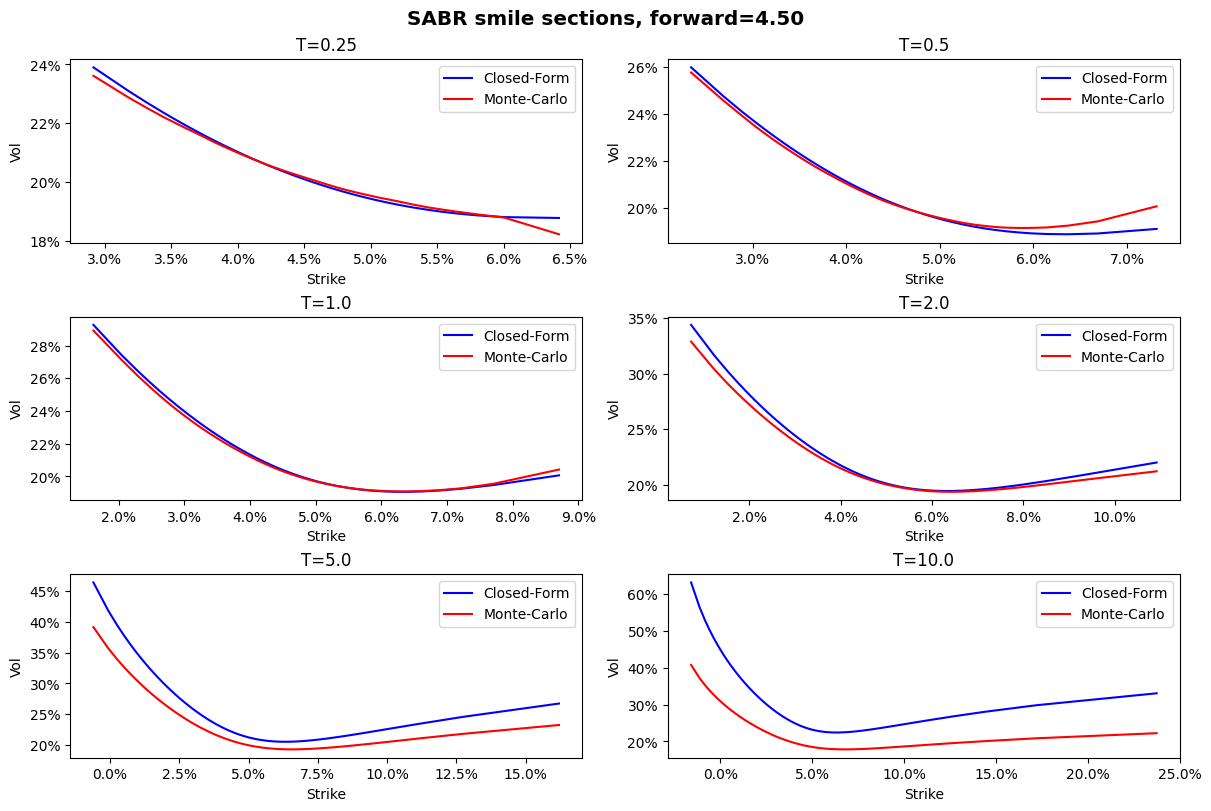

In [5]:
# Calculate same surface with Monte-Carlo. On each MC path we calculate all options on the surface.
NUM_MC = 25000
NUM_TIMESTEPS = 25
timer_mc = Stopwatch("Monte-Carlo")
timer_mc.trigger()
mc_generator = stovolfactory.set_generator("McSABR", shift=SHIFT, num_mc=NUM_MC, points_per_year=NUM_TIMESTEPS)
mc_prices = mc_generator.price_surface_ref(EXPIRIES, strikes, ARE_CALLS, FWD, PARAMS)
timer_mc.stop()
timer_mc.print()

# Draw charts against closed-form
TITLE = f"SABR smile sections, forward={FWD*100:.2f}"#,%\n parameters={PARAMS}"
TRANSFORM = "ShiftedBlackScholes"  # Available transforms: Price, ShiftedBlackScholes, Bachelier
xplt.plot_transform_surface(EXPIRIES, strikes, ARE_CALLS, FWD, cf_prices, mc_prices, TITLE, transform=TRANSFORM,
                            ref_name="Closed-Form", mod_name="Monte-Carlo")


These results show the expected effect of the Hagan closed-form losing accuracy at high strikes and late maturities, while we can see that Monte-Carlo is much slower.

### Classic calibration by optimization
Let us calibrate the classic Hagan model now. At each expiry of the surface, we run an optimizer to find the optimum parameter for a smile made of 13 "market" data points. These market data points are created by a SABR model where statistical noise is added to simulate market noise.

Optimizing at T = [0.25]...
Trying optimization using L-BFGS-B: Good enough!
Optimizing at T = [0.5]...
Trying optimization using L-BFGS-B: Good enough!
Optimizing at T = [1.]...
Trying optimization using L-BFGS-B: Good enough!
Optimizing at T = [2.]...
Trying optimization using L-BFGS-B: Good enough!
Optimizing at T = [5.]...
Trying optimization using L-BFGS-B: Good enough!
Optimizing at T = [10.]...
Trying optimization using L-BFGS-B: Continuing
Trying optimization using Nelder-Mead: Continuing
Trying optimization using DE: Stopping
Calculing calibrated prices
RMSE market-calibration: 0.45
Number of surface evaluations: 3,359
Runtime(Calibration): 19.1s
 Expiry  LnVol-MKT  LnVol-CAL
   0.25        0.2   0.199882
   0.50        0.2   0.200044
   1.00        0.2   0.201060
   2.00        0.2   0.202550
   5.00        0.2   0.202284
  10.00        0.2   0.197498
 Expiry  Beta-MKT  Beta-CAL
   0.25       0.5  0.401304
   0.50       0.5  0.390215
   1.00       0.5  0.738246
   2.00       

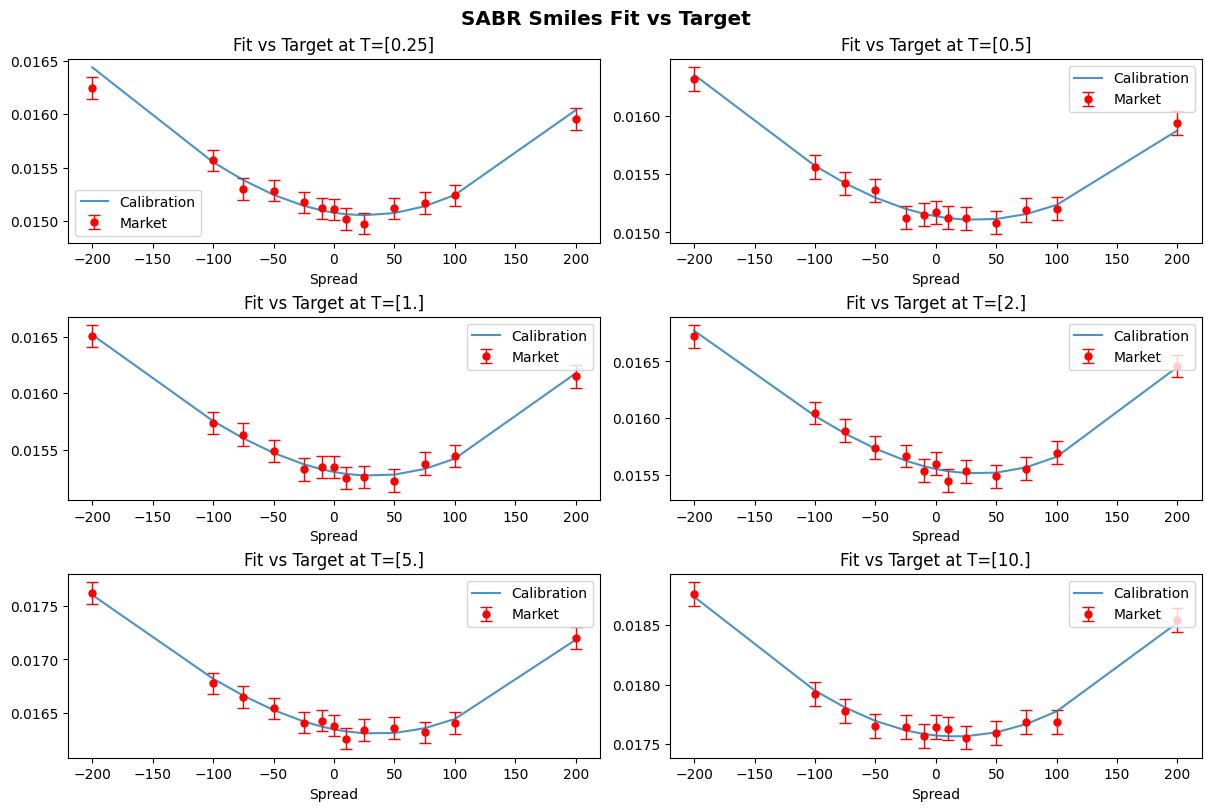

In [6]:
# Calibration (by optimization) and collect the number of function evaluations
SPREADS = [-200, -100, -75, -50, -25, -10, 0, 10, 25, 50, 75, 100, 200]
MARKET_SPREADS = np.asarray(SPREADS)
MARKET_SPREADS = np.tile(MARKET_SPREADS, (NUM_EXPIRIES, 1))
mkt_strikes = MARKET_SPREADS / 10000.0 + FWD

# Calculate market prices and vols
noise = 0.005
noise_prob = 0.99
mkt_vols = cf_generator.price_straddles_ref(EXPIRIES, mkt_strikes, FWD, PARAMS, True,
                                            rel_noise=noise, noise_prob=noise_prob)
mkt_prices = bachelier.price_straddles(EXPIRIES, mkt_strikes, FWD, mkt_vols)

# Calibrate prices by optimization
multi_tol = 1
tol = 1e-8
de_tol = 1e-3
weights = np.asarray([10, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 10])
timer_calib = Stopwatch("Calibration")
timer_calib.trigger()
cal_params, cal_vols, evals = cf_generator.calibrate(EXPIRIES, mkt_strikes, FWD, mkt_prices, weights, True,
                                                     multi_tol=multi_tol, tol=tol, de_tol=de_tol)
timer_calib.stop()
rmse_mkt_cal = bps_rmse(mkt_vols, cal_vols)
print(f"RMSE market-calibration: {rmse_mkt_cal:,.2f}")
print(f"Number of surface evaluations: {evals:,}")
timer_calib.print()

# Display calibrated parameters vs generating
data = {'Expiry': EXPIRIES[:, 0]}
df = pd.DataFrame(data)
df['LnVol-MKT'] = [PARAMS['LnVol']] * NUM_EXPIRIES
df['LnVol-CAL'] = [x['LnVol'] for x in cal_params]
print(df.to_string(index=False))
df = pd.DataFrame(data)
df['Beta-MKT'] = [PARAMS['Beta']] * NUM_EXPIRIES
df['Beta-CAL'] = [x['Beta'] for x in cal_params]
print(df.to_string(index=False))
df = pd.DataFrame(data)
df['Nu-MKT'] = [PARAMS['Nu']] * NUM_EXPIRIES
df['Nu-CAL'] = [x['Nu'] for x in cal_params]
print(df.to_string(index=False))
df = pd.DataFrame(data)
df['Rho-MKT'] = [PARAMS['Rho']] * NUM_EXPIRIES
df['Rho-CAL'] = [x['Rho'] for x in cal_params]
print(df.to_string(index=False))

# Plot calibration vs market prices
lw = 1
cs = 4
ms = 5
onebp = 1 / 10000
yerr = [onebp] * 13
fig, axs = plt.subplots(3, 2, layout="constrained")
fig.suptitle("SABR Smiles Fit vs Target", size='x-large', weight='bold')
fig.set_size_inches(12, 8)

plot_spreads = MARKET_SPREADS[0]
axs[0, 0].errorbar(plot_spreads, mkt_vols[0], yerr, markersize=ms, fmt='o', linewidth=lw, capsize=cs, color='red', label='Market')
axs[0, 0].plot(plot_spreads, cal_vols[0], alpha=0.8, label='Calibration')
axs[0, 0].set_xlabel('Spread')
axs[0, 0].set_title(f"Fit vs Target at T={EXPIRIES[0]}")
axs[0, 0].legend(loc='lower left')

axs[0, 1].errorbar(plot_spreads, mkt_vols[1], yerr, markersize=ms, fmt='o', linewidth=lw, capsize=cs, color='red', label='Market')
axs[0, 1].plot(plot_spreads, cal_vols[1], alpha=0.8, label='Calibration')
axs[0, 1].set_xlabel('Spread')
axs[0, 1].set_title(f"Fit vs Target at T={EXPIRIES[1]}")
axs[0, 1].legend(loc='upper right')

axs[1, 0].errorbar(plot_spreads, mkt_vols[2], yerr, markersize=ms, fmt='o', linewidth=lw, capsize=cs, color='red', label='Market')
axs[1, 0].plot(plot_spreads, cal_vols[2], alpha=0.8, label='Calibration')
axs[1, 0].set_xlabel('Spread')
axs[1, 0].set_title(f"Fit vs Target at T={EXPIRIES[2]}")
axs[1, 0].legend(loc='upper right')

axs[1, 1].errorbar(plot_spreads, mkt_vols[3], yerr, markersize=ms, fmt='o', linewidth=lw, capsize=cs, color='red', label='Market')
axs[1, 1].plot(plot_spreads, cal_vols[3], alpha=0.8, label='Calibration')
axs[1, 1].set_xlabel('Spread')
axs[1, 1].set_title(f"Fit vs Target at T={EXPIRIES[3]}")
axs[1, 1].legend(loc='upper right')

axs[2, 0].errorbar(plot_spreads, mkt_vols[4], yerr, markersize=ms, fmt='o', linewidth=lw, capsize=cs, color='red', label='Market')
axs[2, 0].plot(plot_spreads, cal_vols[4], alpha=0.8, label='Calibration')
axs[2, 0].set_xlabel('Spread')
axs[2, 0].set_title(f"Fit vs Target at T={EXPIRIES[4]}")
axs[2, 0].legend(loc='upper right')

axs[2, 1].errorbar(plot_spreads, mkt_vols[5], yerr, markersize=ms, fmt='o', linewidth=lw, capsize=cs, color='red', label='Market')
axs[2, 1].plot(plot_spreads, cal_vols[5], alpha=0.8, label='Calibration')
axs[2, 1].set_xlabel('Spread')
axs[2, 1].set_title(f"Fit vs Target at T={EXPIRIES[5]}")
axs[2, 1].legend(loc='upper right')

plt.show()

### Summary
* Interpolation models easily fit the market data but can have poor smoothness properties leading to bad Greeks, or can suffer from arbitrage
* Parametric math-based models will be smoother with better Greeks and may have intuitive properties, but can still suffer from arbitrage
* SDE based models lead to smooth prices and are abitrage-free, but very few have closed-forms
* Models with closed-forms can be too limiting in realism, risk behaviour or even ability to fit
* Closed-forms can be quite heavy to calculate and not always very reliable (e.g. Free-Boundary SABR)
* Calibration by optimization requires a lot of function evaluations and results are not always smooth. Isn't there another way?

### What we'd like to do, ideally

* use any model through an SDE with full freedom on the specs: local vol, stochastic component, jumps, etc.
* have a generic calibration method that does not require new (long creative) work when changing the model
* calibrate it very quickly and smoothly intra-day/for scenarios
* calibrate to non-vanillas?
* either evaluation of vanillas must very fast (in iterative search/optimization)
* or we do away with optimization?

<div class="alert alert-block alert-success">
&rarr; Let's see how Deep Learning can help!
</div>

## 2) Deep Learning for Pricing
* Learn the price function $f()$ with a neural network

    $$ Option Price = f(\alpha, \beta, \nu, \rho) $$

* Calibration still done by optimization on the price function
* Neural network evaluation is typically very fast (matrix multiplications and activation calls)
* The network's inputs are the model parameters and its outputs are the option prices

Let us proceed with the following steps:
>* Generate the dataset
>* Process the dataset (split into training and testing)
>* Decide a network topology (hidden layers, #neurons, activations)
>* Train the network
>* Test the result/measure performance

### Generate the dataset
* Outputs are prices (output)
* Inputs are model parameters, option specs (maturity, strike) and market data (forward)
* Input points are generated randomly (as many as we want)
* For each multi-dimensional input point we calculate a price (1-dimensional output)
* Data cleansing using transformation to normal vol
* Inputs and outputs are collected in dataframe rows/text files

In [7]:
NUM_GEN_SAMPLES = 10000

# Select parameter ranges
RANGES = {'Ttm': [1.0 / 12.0, 35.0], 'K': [0.01, 0.99], 'F': [-0.009, 0.041], 'LnVol': [0.05, 0.5],
          'Beta': [0.1, 0.9], 'Nu': [0.1, 1.0], 'Rho': [-0.6, 0.6]}

# Generate samples
print(f"Generate {NUM_GEN_SAMPLES:,} price samples")
data_df = cf_generator.generate_samples(NUM_GEN_SAMPLES, RANGES)

print("Convert to normal vol and cleanse data")
num_total = len(data_df.index)
data_df = cf_generator.to_nvol(data_df, cleanse=True)
num_final = len(data_df.index)
print(f"Dataset size before cleansing: {num_total:,}")
print(f"Dataset size removed: {num_total - num_final:,}")
print(f"Dataset size after cleansing: {num_final:,}")

now = datetime.now()
dt_string = now.strftime("%Y%m%d-%H_%M_%S")
data_file = os.path.join(pr_dataset_folder, "SABR_data_" + dt_string + ".tsv")
print("> Output to file: " + data_file)
cf_generator.to_file(data_df, data_file)

Generate 10,000 price samples
Number of strikes: 5
Number of expiries: 10
Surface size: 50
Number of samples: 10,000
Number of surfaces/parameter samples: 200
Surface generation number 1/200
Surface generation number 2/200
Surface generation number 3/200
Surface generation number 4/200
Surface generation number 5/200
Surface generation number 6/200
Surface generation number 7/200
Surface generation number 8/200
Surface generation number 9/200
Surface generation number 10/200
Surface generation number 11/200
Surface generation number 12/200
Surface generation number 13/200
Surface generation number 14/200
Surface generation number 15/200
Surface generation number 16/200
Surface generation number 17/200
Surface generation number 18/200
Surface generation number 19/200
Surface generation number 20/200
Surface generation number 21/200
Surface generation number 22/200
Surface generation number 23/200
Surface generation number 24/200
Surface generation number 25/200
Surface generation number

### Process the dataset
* A large number of data points have been created at the previous step
* Now we create the dataset we will train on
* The data is reshuffled randomly
* Then we split it into training and testing sets to check out-of-sample

In [17]:
NUM_DATASET = 100 * 1000 # Total number of points selected to build dataset
TRAIN_PERCENT = 0.05 # Proportion of dataset used for training vs testing

# Retrieve data from dataset folder and output to temp file
print(f"Requested samples: {NUM_DATASET:,}")
pr_dataset_file = os.path.join(pr_data_folder, "dataset.tsv")
datasets.retrieve_data(pr_dataset_folder, NUM_DATASET, shuffle=True, export_file=pr_dataset_file)
print("Exporting dataset to file: " + pr_dataset_file)

# Retrieve dataset
print("Reading dataset from file: " + pr_dataset_file)
# generator = stovolfactory.set_generator("SABR", SHIFT, num_expiries=NUM_EXPIRIES, seed=42)
x_set, y_set, data_df = cf_generator.retrieve_datasets(pr_dataset_file, shuffle=True)
pr_input_dim = x_set.shape[1]
pr_output_dim = y_set.shape[1]
print(f"Samples found: {x_set.shape[0]:,}")
print(f"Input dimension: {pr_input_dim:,}")
print(f"Output dimension (parameters): {pr_output_dim:,}")

# Split into training and test sets
TRS = TRAIN_PERCENT * 100
print(f"Splitting between training set ({TRS:.2f}%) and test set ({100 - TRS:.2f}%)")
pr_x_train, pr_y_train, pr_x_test, pr_y_test = datasets.prepare_sets(x_set, y_set, TRAIN_PERCENT)
print(f"Training set size: {pr_x_train.shape[0]:,}")
print(f"Testing set size: {pr_x_test.shape[0]:,}")

Requested samples: 100,000
Exporting dataset to file: C:\\temp\\demo\\pricing\\data\dataset.tsv
Reading dataset from file: C:\\temp\\demo\\pricing\\data\dataset.tsv
Samples found: 100,000
Input dimension: 7
Output dimension (parameters): 1
Splitting between training set (5.00%) and test set (95.00%)
Training set size: 5,000
Testing set size: 95,000


### Define the network topology
* Number of neurons in the initial layer is fixed to the dimension of input points
* Number of neurons in the output layer is fixed to the dimension of outputs (1)
* Specify number of hidden layers
* Specify number of neurons per hidden layer
* Specify [activation functions](https://keras.io/api/layers/activations/), for instance
* We are not using the drop-out feature

Text(0.5, 1.0, 'softplus')

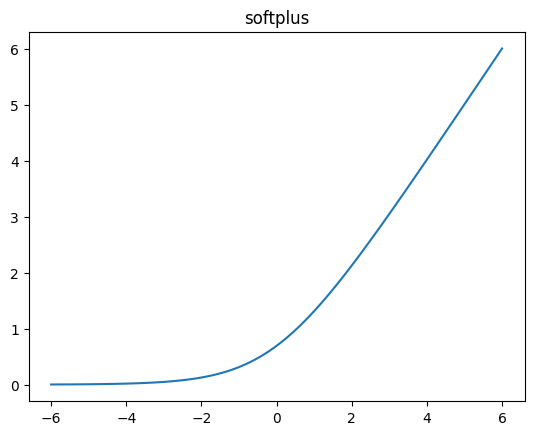

In [9]:
# Take a look at the chosen activation function
af_x = np.linspace(-6, 6, 100)
plt.plot(af_x, keras.activations.softplus(af_x), label='softplus')
plt.title('softplus')

In [19]:
HIDDEN_LAYERS = ['softplus', 'softplus', 'softplus', 'softplus', 'softplus']
NUM_NEURONS = 128
DROP_OUT = 0.0
pr_demo_keras_model = compose_model(pr_input_dim, pr_output_dim, HIDDEN_LAYERS, NUM_NEURONS, DROP_OUT)
pr_demo_topology = { 'layers': HIDDEN_LAYERS, 'neurons': NUM_NEURONS, 'dropout': DROP_OUT}

pr_demo_model = LearningModel(pr_demo_keras_model)
pr_demo_model.topology_ = pr_demo_topology

print(f"Hidden layer structure: {HIDDEN_LAYERS}")
print(f"Number of neurons per layer: {NUM_NEURONS}")
print(f"Drop-out rate: {DROP_OUT:.2f}")

Hidden layer structure: ['softplus', 'softplus', 'softplus', 'softplus', 'softplus']
Number of neurons per layer: 128
Drop-out rate: 0.00


### Train the network
Training the model requires choices for a number of training hyperparameters:
* the number of epochs (full runs through the dataset)
* the batch size (number of points calculated before we update the weights)
* the algorithm (SGD, Rprop, Adam, etc.)
* learning rate and its schedule
* SDevPy has customized callbacks to calculate and collect history on test data

Optimizer settings
name : adam
learning_rate : {'module': 'sdevpy.machinelearning.learningschedules', 'class_name': 'FlooredExponentialDecay', 'config': {'initial_lr': 0.01, 'final_lr': 1e-05, 'decay': 0.0001001001001001001, 'decay_steps': 4500.0}, 'registered_name': 'FlooredExponentialDecay'}
weight_decay : None
clipnorm : None
global_clipnorm : None
clipvalue : None
use_ema : False
ema_momentum : 0.99
ema_overwrite_frequency : None
loss_scale_factor : None
gradient_accumulation_steps : None
beta_1 : 0.9
beta_2 : 0.999
epsilon : 1e-07
amsgrad : False
Compile model
Training ANN model
<><><><><><><><> TRAINING START <><><><><><><><>
Epochs: 50
Batch size: 1,000
Shuffle: True
Training set size: 5,000
<><><><><><><><><><><><><><><><>
Epoch 0/50
Loss: 65,068.77, LR: 0.009898, Test loss: 19,025.64
<><><><><><><><><><><><><><><><>
Epoch 1/50
Loss: 14,540.82, LR: 0.009798, Test loss: 12,597.19
<><><><><><><><><><><><><><><><>
Epoch 2/50
Loss: 10,964.20, LR: 0.009698, Test loss: 11,033.37
<><>

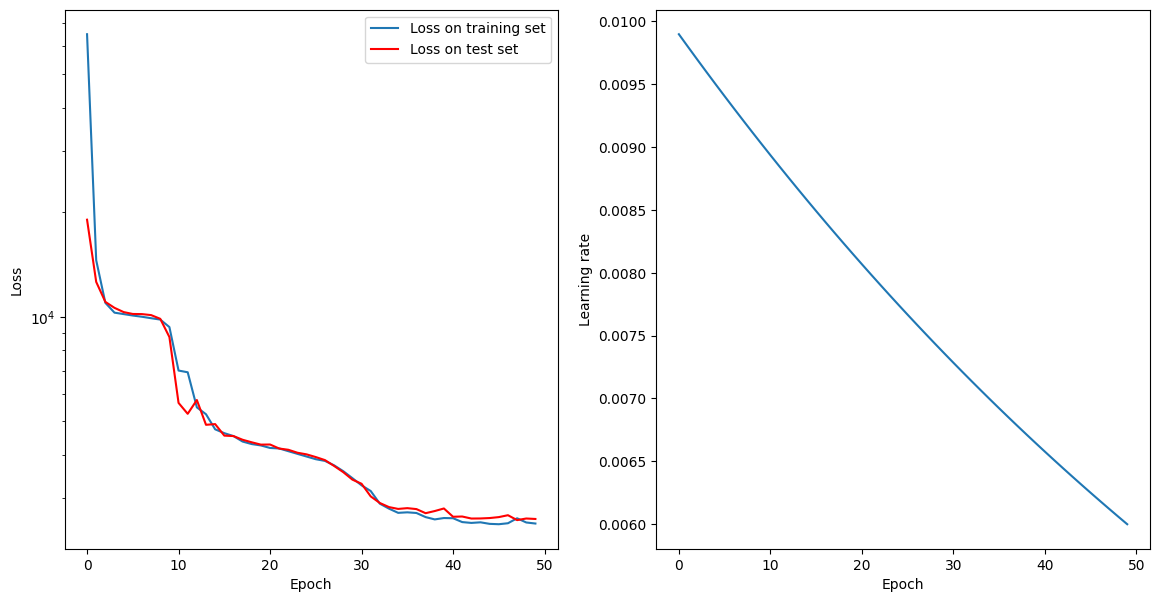

In [20]:
EPOCHS = 50
BATCH_SIZE = 1000
# LR_TYPE = 'Constant'
LR_TYPE = 'ExpDec'
# LR_TYPE = 'Cyclical'


# Learning rate scheduler
INIT_LR = 1.0e-2#1.0e-2
FINAL_LR = 1.0e-5#1.0e-4
TARGET_EPOCH = EPOCHS * 0.90  # Epoch by which we plan to be down to 110% of final LR
PERIODS = 10  # Number of oscillation periods until target epoch

if LR_TYPE == 'Constant':
    lr_schedule = INIT_LR
elif LR_TYPE == 'ExpDec':
    lr_schedule = FlooredExponentialDecay(NUM_DATASET, BATCH_SIZE, TARGET_EPOCH, INIT_LR, FINAL_LR)
else:
    lr_schedule = CyclicalExponentialDecay(NUM_DATASET, BATCH_SIZE, TARGET_EPOCH, INIT_LR, FINAL_LR, PERIODS)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
pr_demo_model.optimizer_ = optimizer.get_config()
print("Optimizer settings")
optim_fields = pr_demo_model.optimizer_
for field, value in optim_fields.items():
    print(field, ":", value)

# Compile
print("Compile model")
pr_demo_keras_model.compile(loss=tf_bps_rmse, optimizer=optimizer)

# Callbacks
EPOCH_SAMPLING = 1
callback = RefCallback(pr_x_test, pr_y_test, bps_rmse, optimizer=optimizer,
                       epoch_sampling=EPOCH_SAMPLING, x_train=pr_x_train, y_train=pr_y_train)

# Train the network
print("Training ANN model")
pr_demo_model.train(pr_x_train, pr_y_train, EPOCHS, BATCH_SIZE, callback)

# Saving model to file
now = datetime.now()
dt_string = now.strftime("%Y%m%d-%H_%M_%S")
model_folder_name = os.path.join(pr_model_folder, "SABR_demo")
print("Saving model to: " + model_folder_name)
pr_demo_model.save(model_folder_name)

# Show training charts
hist_epochs = callback.epochs
hist_losses = callback.losses
hist_lr = callback.learning_rates
sampled_epochs = callback.sampled_epochs
test_losses = callback.test_losses

plt.figure(figsize=(14, 7))
plt.subplots_adjust(hspace=0.40)
plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.plot(hist_epochs, hist_losses, label='Loss on training set')
plt.plot(sampled_epochs, test_losses, color='red', label='Loss on test set')
plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.plot(hist_epochs, hist_lr)
plt.show()

### Load pre-trained model
Alternatively one can load a model that has already been traded and saved into a file format (can also be re-trained).

In [22]:
pr_model_path = os.path.join(pr_model_folder, "SABR")
print("Loading pre-trained model from: " + pr_model_path)
pr_pt_model = load_learning_model(pr_model_path)
pr_pt_keras_model = pr_pt_model.model
HIDDEN_LAYERS = NUM_NEURONS = DROP_OUT = None
topology = pr_pt_model.topology_
if topology is not None:
    HIDDEN_LAYERS = topology['layers']
    NUM_NEURONS = topology['neurons']
    DROP_OUT = topology['dropout']

print(f"Hidden layer structure: {HIDDEN_LAYERS}")
print(f"Number of neurons per layer: {NUM_NEURONS}")
print(f"Drop-out rate: {DROP_OUT:.2f}")

Loading pre-trained model from: C:\\temp\\demo\\pricing\\models\SABR
Hidden layer structure: ['softplus', 'softplus', 'softplus']
Number of neurons per layer: 64
Drop-out rate: 0.00


### Test performance
* First we look at the RMSE on the training set and test set. These should be similar, otherwise there is a danger of overfitting.
* Next we specify a set of SABR parameters and calculate the options both with the SABR formula and with the trained model

RMSE(nvol) on training set: 0.50
RMSE(nvol) on test set: 2.10
Choosing a sample parameter set to display chart
Calculating chart surface with reference model
Calculating chart surface with trained model
Ref-Mod RMSE(price): 0.16
Runtime(Reference surface calculation): 0.1s
Runtime(Model surface calculation): 0.1s


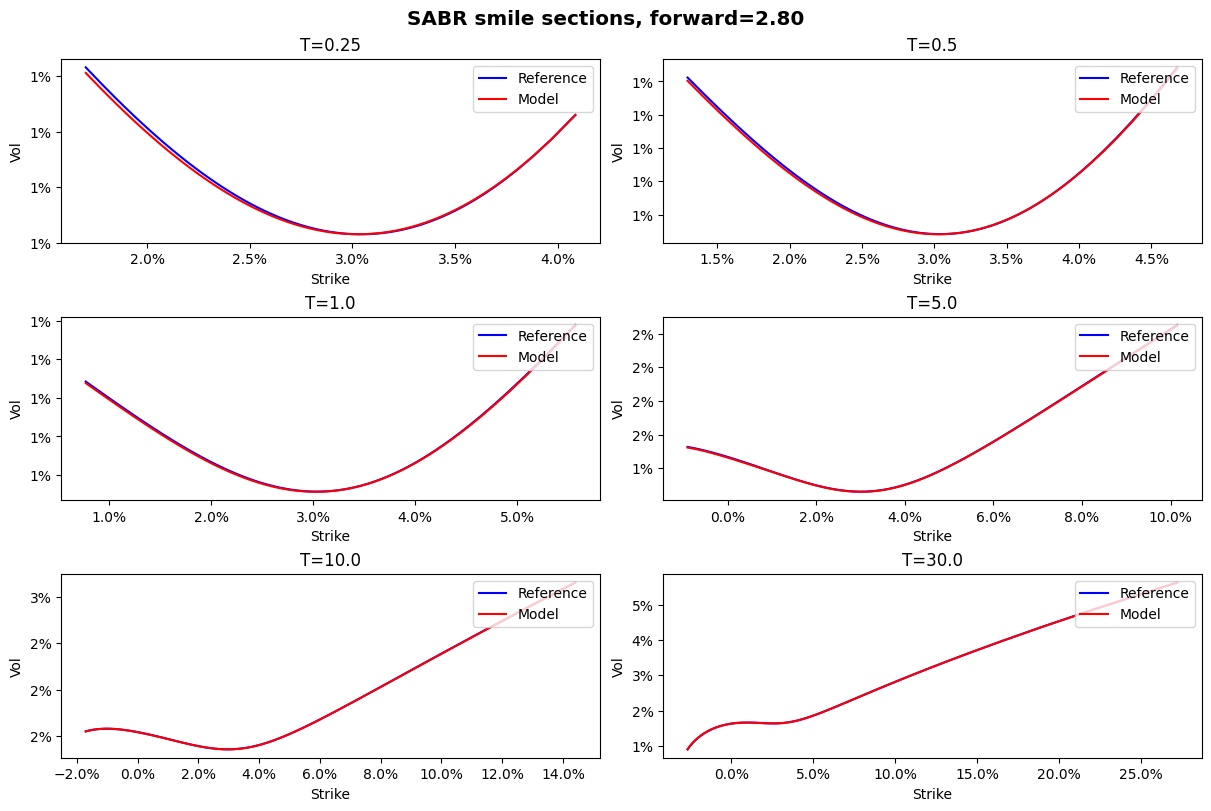

In [24]:
# Choose to test on-the-fly model or pre-trained
PRICING_USE_PRETRAINED = True

# Check performance
pr_test_model = pr_pt_model if PRICING_USE_PRETRAINED else pr_demo_model
pr_train_pred = pr_test_model.predict(pr_x_train)
pr_train_rmse = bps_rmse(pr_train_pred, pr_y_train)
print(f"RMSE(nvol) on training set: {pr_train_rmse:,.2f}")

pr_test_pred = pr_test_model.predict(pr_x_test)
pr_test_rmse = bps_rmse(pr_test_pred, pr_y_test)
print(f"RMSE(nvol) on test set: {pr_test_rmse:,.2f}")

# Generate strike spread axis
print("Choosing a sample parameter set to display chart")
NUM_STRIKES = 100
PARAMS = { 'LnVol': 0.20, 'Beta': 0.5, 'Nu': 0.55, 'Rho': -0.25 }
FWD = 0.028

# Any number of expiries can be calculated, but for optimum display choose no more than 6
EXPIRIES = np.asarray([0.25, 0.50, 1.0, 5.0, 10.0, 30.0]).reshape(-1, 1)
NUM_EXPIRIES = EXPIRIES.shape[0]
METHOD = 'Percentiles'
PERCENTS = np.linspace(0.02, 0.98, num=NUM_STRIKES)
PERCENTS = np.asarray([PERCENTS] * NUM_EXPIRIES)

strikes = cf_generator.convert_strikes(EXPIRIES, PERCENTS, FWD, PARAMS, METHOD)
ARE_CALLS = [[False] * NUM_STRIKES] * NUM_EXPIRIES # All puts
# ARE_CALLS = [[False if s < FWD else True for s in expks] for expks in strikes] # Puts/calls

print("Calculating chart surface with reference model")
timer_ref = Stopwatch("Reference surface calculation")
timer_ref.trigger()
ref_prices = cf_generator.price_surface_ref(EXPIRIES, strikes, ARE_CALLS, FWD, PARAMS)
timer_ref.stop()
print("Calculating chart surface with trained model")
timer_mod = Stopwatch("Model surface calculation")
timer_mod.trigger()
mod_prices = cf_generator.price_surface_mod(pr_test_model, EXPIRIES, strikes, ARE_CALLS, FWD, PARAMS)
timer_mod.stop()
print(f"Ref-Mod RMSE(price): {bps_rmse(ref_prices, mod_prices):.2f}")

# Display timers
timer_ref.print()
timer_mod.print()

# Available tranforms: Price, ShiftedBlackScholes, Bachelier
TITLE = f"SABR smile sections, forward={FWD*100:.2f}"#,%\n parameters={PARAMS}"
TRANSFORM = "Bachelier"
# TRANSFORM = "Price"
# TRANSFORM = "ShiftedBlackScholes"
xplt.plot_transform_surface(EXPIRIES, strikes, ARE_CALLS, FWD, ref_prices, mod_prices,
                            TITLE, transform=TRANSFORM)

### Conclusions
The whole process involves a lot of choices that affect the result:
* Amount of data
* Number of layers, number of neurons per layers, activation functions
* Training algorithm
* Epochs, batch size
* Learning schedule

Overall it is quite difficult to obtain a good fit. However, with a lot of trial and error and experimenting, we can see that it is possible to get very good results. It should be noted that the results extend readily to other models than SABR, as can be seen in [[Gurrieri 2023]](https://colab.research.google.com/drive/1y-Tb4JxiBmcJAw943GWtZn_GiGhcUUzS?usp=sharing).

## 3) Deep Learning for Calibration
Next we reverse the dataset by using the prices as inputs and the parameters as outputs.

### Generate the dataset
* Inputs are prices, option specs (maturity, strike) and market data (forward) [15D]
* Outputs are model parameters [4D]
* Model parameters are generated randomly (as many as we want)
* For each set of model parmeters we calculate prices at market spreads

In [25]:
NUM_GEN_SAMPLES = 1 * 1000

NOISE_PROB = 0.0  # Probability of point having noise
NOISE = 0.0  # Noise size (relative)

# Select parameter ranges
RANGES = {'Ttm': [1.0 / 12.0, 35.0], 'F': [0.05, 0.06], 'LnVol': [0.20, 0.40],
          'Beta': [0.1, 0.9], 'Nu': [0.2, 1.0], 'Rho': [-0.5, 0.2]} #  All times

# Generate samples
print(f"Generate {NUM_GEN_SAMPLES:,} price samples")
data_df = cf_generator.generate_samples_inverse(NUM_GEN_SAMPLES, RANGES, SPREADS, use_nvol=True,
                                                rel_noise=NOISE, noise_prob=NOISE_PROB)

now = datetime.now()
dt_string = now.strftime("%Y%m%d-%H_%M_%S")
data_file = os.path.join(ca_dataset_folder, "SABR_data_" + dt_string + ".tsv")
print("Output to file: " + data_file)
cf_generator.to_file(data_df, data_file)

Generate 1,000 price samples
[-200, -100, -75, -50, -25, -10, 0, 10, 25, 50, 75, 100, 200]
(13, 1)
Number of strikes: 13
Number of expiries: 10
Surface size: 130
Number of samples: 1,000
Minimum forward: 5.00%
Number of surfaces/parameter samples: 100
Surface generation number 1/100
Surface generation number 2/100
Surface generation number 3/100
Surface generation number 4/100
Surface generation number 5/100
Surface generation number 6/100
Surface generation number 7/100
Surface generation number 8/100
Surface generation number 9/100
Surface generation number 10/100
Surface generation number 11/100
Surface generation number 12/100
Surface generation number 13/100
Surface generation number 14/100
Surface generation number 15/100
Surface generation number 16/100
Surface generation number 17/100
Surface generation number 18/100
Surface generation number 19/100
Surface generation number 20/100
Surface generation number 21/100
Surface generation number 22/100
Surface generation number 23/10

### Process the dataset
As before, we collect the data points, shuffle, and split between training and test sets.

In [27]:
NUM_DATASET = 10 * 1000 # Total number of points selected to build dataset
TRAIN_PERCENT = 0.90 # Proportion of dataset used for training vs testing

# Retrieve data from dataset folder and output to temp file
print(f"Requested samples: {NUM_DATASET:,}")
ca_dataset_file = os.path.join(ca_data_folder, "dataset.tsv")
datasets.retrieve_data(ca_dataset_folder, NUM_DATASET, shuffle=True, export_file=ca_dataset_file)
print("Exporting dataset to file: " + ca_dataset_file)

# Retrieve dataset
print("Reading dataset from file: " + ca_dataset_file)
x_set, y_set, data_df = cf_generator.retrieve_inverse_datasets(ca_dataset_file, shuffle=True)
ca_input_dim = x_set.shape[1]
ca_output_dim = y_set.shape[1]
print(f"Samples found: {x_set.shape[0]:,}")
print(f"Input dimension: {ca_input_dim:,}")
print(f"Output dimension (parameters): {ca_output_dim:,}")

# Split into training and test sets
TRS = TRAIN_PERCENT * 100
print(f"Splitting between training set ({TRS:.2f}%) and test set ({100 - TRS:.2f}%)")
ca_x_train, ca_y_train, ca_x_test, ca_y_test = datasets.prepare_sets(x_set, y_set, TRAIN_PERCENT)
print(f"Training set size: {ca_x_train.shape[0]:,}")
print(f"Testing set size: {ca_x_test.shape[0]:,}")

Requested samples: 10,000
Exporting dataset to file: C:\\temp\\demo\\calibration\\data\dataset.tsv
Reading dataset from file: C:\\temp\\demo\\calibration\\data\dataset.tsv
> Number of strikes: 13
Samples found: 10,000
Input dimension: 15
Output dimension (parameters): 4
Splitting between training set (90.00%) and test set (10.00%)
Training set size: 9,000
Testing set size: 1,000


### Define the network topology
Double the number of neurons for this exercise, seems to be helpful.

In [28]:
HIDDEN_LAYERS = ['softplus', 'softplus', 'softplus']
NUM_NEURONS = 64
DROP_OUT = 0.0
ca_demo_keras_model = compose_model(ca_input_dim, ca_output_dim, HIDDEN_LAYERS, NUM_NEURONS, DROP_OUT)
ca_demo_topology = { 'layers': HIDDEN_LAYERS, 'neurons': NUM_NEURONS, 'dropout': DROP_OUT}

ca_demo_model = LearningModel(ca_demo_keras_model)
ca_demo_model.topology_ = ca_demo_topology

print(f"Hidden layer structure: {HIDDEN_LAYERS}")
print(f"Number of neurons per layer: {NUM_NEURONS}")
print(f"Drop-out rate: {DROP_OUT:.2f}")

Hidden layer structure: ['softplus', 'softplus', 'softplus']
Number of neurons per layer: 64
Drop-out rate: 0.00


### Train the network
Very similar training choices as for the direct map.

Optimizer settings
name : adam
learning_rate : {'module': 'sdevpy.machinelearning.learningschedules', 'class_name': 'FlooredExponentialDecay', 'config': {'initial_lr': 0.01, 'final_lr': 1e-05, 'decay': 0.0001001001001001001, 'decay_steps': 90.0}, 'registered_name': 'FlooredExponentialDecay'}
weight_decay : None
clipnorm : None
global_clipnorm : None
clipvalue : None
use_ema : False
ema_momentum : 0.99
ema_overwrite_frequency : None
loss_scale_factor : None
gradient_accumulation_steps : None
beta_1 : 0.9
beta_2 : 0.999
epsilon : 1e-07
amsgrad : False
Compile model
Training ANN model
<><><><><><><><> TRAINING START <><><><><><><><>
Epochs: 10
Batch size: 1,000
Shuffle: True
Training set size: 9,000
<><><><><><><><><><><><><><><><>
Epoch 0/10
Loss: 11,635.40, LR: 0.003987, Test loss: 9,247.88
<><><><><><><><><><><><><><><><>
Epoch 1/10
Loss: 9,066.23, LR: 0.001594, Test loss: 9,006.75
<><><><><><><><><><><><><><><><>
Epoch 2/10
Loss: 8,936.37, LR: 0.000641, Test loss: 8,896.83
<><><><><><

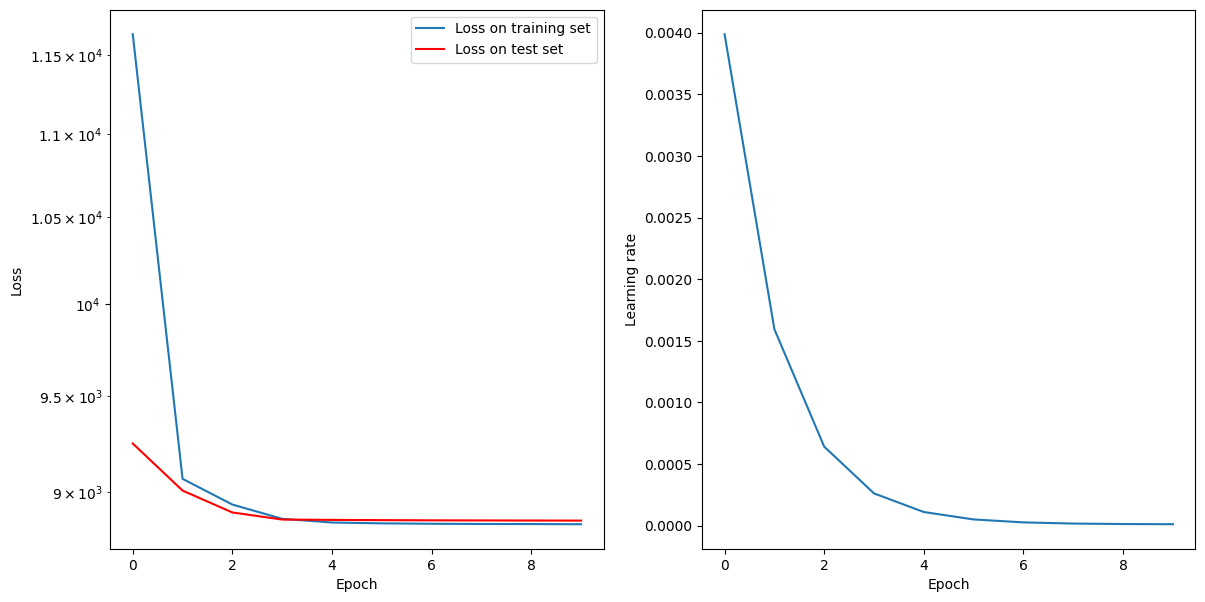

In [29]:
EPOCHS = 10
BATCH_SIZE = 1000
# LR_TYPE = 'Constant'
LR_TYPE = 'ExpDec'
# LR_TYPE = 'Cyclical'

# Learning rate scheduler
INIT_LR = 1.0e-2#1.0e-2
FINAL_LR = 1.0e-5#1.0e-4
TARGET_EPOCH = EPOCHS * 0.90  # Epoch by which we plan to be down to 110% of final LR
PERIODS = 10  # Number of oscillation periods until target epoch

if LR_TYPE == 'Constant':
    lr_schedule = INIT_LR
elif LR_TYPE == 'ExpDec':
    lr_schedule = FlooredExponentialDecay(NUM_DATASET, BATCH_SIZE, TARGET_EPOCH, INIT_LR, FINAL_LR)
else:
    lr_schedule = CyclicalExponentialDecay(NUM_DATASET, BATCH_SIZE, TARGET_EPOCH, INIT_LR, FINAL_LR, PERIODS)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
ca_demo_model.optimizer_ = optimizer.get_config()
print("Optimizer settings")
optim_fields = ca_demo_model.optimizer_
for field, value in optim_fields.items():
    print(field, ":", value)

# Compile
print("Compile model")
ca_demo_keras_model.compile(loss=tf_bps_rmse, optimizer=optimizer)

# Callbacks
EPOCH_SAMPLING = 1
callback = RefCallback(ca_x_test, ca_y_test, bps_rmse, optimizer=optimizer,
                       epoch_sampling=EPOCH_SAMPLING, x_train=ca_x_train, y_train=ca_y_train)

# Train the network
print("Training ANN model")
ca_demo_model.train(ca_x_train, ca_y_train, EPOCHS, BATCH_SIZE, callback)

# Saving model to file
now = datetime.now()
dt_string = now.strftime("%Y%m%d-%H_%M_%S")
model_folder_name = os.path.join(ca_model_folder, "SABR_demo")
print("Saving model to: " + model_folder_name)
ca_demo_model.save(model_folder_name)

# Show training charts
hist_epochs = callback.epochs
hist_losses = callback.losses
hist_lr = callback.learning_rates
sampled_epochs = callback.sampled_epochs
test_losses = callback.test_losses

plt.figure(figsize=(14, 7))
plt.subplots_adjust(hspace=0.40)
plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.plot(hist_epochs, hist_losses, label='Loss on training set')
plt.plot(sampled_epochs, test_losses, color='red', label='Loss on test set')
plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.plot(hist_epochs, hist_lr)
plt.show()

### Load pre-trained model
We have prepared two pre-trained models to illustrate the effect of noise in the dataset. One model was trained without noise, the other with noise.

In [41]:
# model_id = "SABR" # Trained without noise
model_id = "SABR.noise" # Trained with noise
ca_model_path = os.path.join(ca_model_folder, model_id)
print("Loading pre-trained model from: " + ca_model_path)
ca_pt_model = load_learning_model(ca_model_path)
ca_pt_keras_model = ca_pt_model.model
HIDDEN_LAYERS = NUM_NEURONS = DROP_OUT = None
topology = ca_pt_model.topology_
if topology is not None:
    HIDDEN_LAYERS = topology['layers']
    NUM_NEURONS = topology['neurons']
    DROP_OUT = topology['dropout']

print(f"Hidden layer structure: {HIDDEN_LAYERS}")
print(f"Number of neurons per layer: {NUM_NEURONS}")
print(f"Drop-out rate: {DROP_OUT:.2f}")

Loading pre-trained model from: C:\\temp\\demo\\calibration\\models\SABR.noise
Hidden layer structure: ['softplus', 'softplus', 'softplus']
Number of neurons per layer: 128
Drop-out rate: 0.00


### Test performance
As before, we first compare the RMSE on the training and test sets.

In [42]:
# Choose to test on-the-fly model or pre-trained
CALIB_USE_PRETRAINED = True

# Check performance
ca_test_model = ca_pt_model if CALIB_USE_PRETRAINED else ca_demo_model
ca_train_pred = ca_test_model.predict(ca_x_train)
ca_train_rmse = bps_rmse(ca_train_pred, ca_y_train)
print(f"RMSE on training set: {ca_train_rmse:,.2f}")

ca_test_pred = ca_test_model.predict(ca_x_test)
ca_test_rmse = bps_rmse(ca_test_pred, ca_y_test)
print(f"RMSE on test set: {ca_test_rmse:,.2f}")

RMSE on training set: 991.95
RMSE on test set: 999.99


Next we want to compare the performances of the classic calibration by optimization on SABR formula against the neural network. To this end, we:
* Generate a set of "market prices" by picking a SABR model and calculating its volatilities, possibly adding noise
* Calibrate using classic optimization
* Give the prices to the neural network and let it output the parameters
* Compare the results

Choosing a sample parameter set to display chart
<><> Deep-Learning Calibration <><>
Done!
<><> Classic Calibration <><>
Optimizing at T = [0.25]...
Trying optimization using L-BFGS-B: Good enough!
Optimizing at T = [0.5]...
Trying optimization using L-BFGS-B: Good enough!
Optimizing at T = [1.]...
Trying optimization using L-BFGS-B: Good enough!
Optimizing at T = [5.]...
Trying optimization using L-BFGS-B: Good enough!
Optimizing at T = [10.]...
Trying optimization using L-BFGS-B: Good enough!
Optimizing at T = [30.]...
Trying optimization using L-BFGS-B: Continuing
Trying optimization using Nelder-Mead: Good enough!
Calculing calibrated prices
Done!
RMSE Deep-Learning: 5.10
RMSE Classic: 0.94
Runtime(Deep Calibration): 0.1s
Runtime(Classic Calibration): 11.5s
Speed gain: 186X


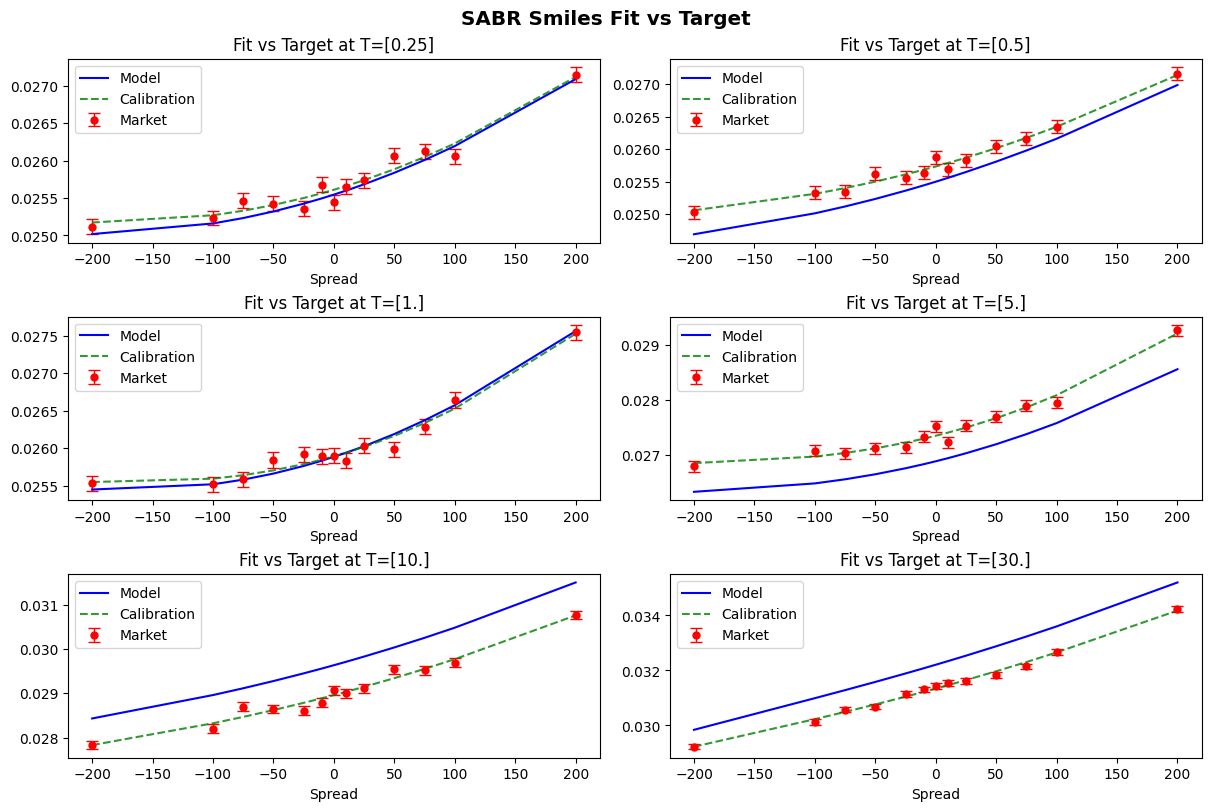

In [44]:
# Choose sample parameter set
print("Choosing a sample parameter set to display chart")
PARAMS = { 'LnVol': 0.30, 'Beta': 0.5, 'Nu': 0.50, 'Rho': -0.10  }
FWD = 0.055

# Choose expiries
EXPIRIES = np.asarray([0.25, 0.50, 1.0, 5.0, 10.0, 30.0]).reshape(-1, 1)
NUM_EXPIRIES = EXPIRIES.shape[0]

# Calculate market strikes and prices on the training spreads
TRAINING_SPREADS = SPREADS.copy()
TRAINING_SPREADS = np.asarray(TRAINING_SPREADS)
TRAINING_SPREADS = np.tile(TRAINING_SPREADS, (NUM_EXPIRIES, 1))
mkt_strikes = TRAINING_SPREADS / 10000.0 + FWD

# Calculate market prices and vols
noise = 0.008# 0.008
noise_prob = 0.6 #0.99
mkt_vols = cf_generator.price_straddles_ref(EXPIRIES, mkt_strikes, FWD, PARAMS, True,
                                            rel_noise=noise, noise_prob=noise_prob)
mkt_prices = bachelier.price_straddles(EXPIRIES, mkt_strikes, FWD, mkt_vols)

# Use model to get parameters at each expiry, then calculate parameters and then prices
print("<><> Deep-Learning Calibration <><>")
timer_ca_model = Stopwatch("Deep Calibration")
timer_ca_model.trigger()
mod_params, mod_vols = cf_generator.price_straddles_mod(ca_test_model, EXPIRIES, mkt_strikes, FWD,
                                                        mkt_vols, True)
timer_ca_model.stop()
print("Done!")
rmse_mkt_mod = bps_rmse(mkt_vols, mod_vols)

# Calibrate prices by optimization
print("<><> Classic Calibration <><>")
weights = np.asarray([10, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 10])
multi_tol = 5
tol = 1e-8
de_tol = 1e-3
timer_ca_calib = Stopwatch("Classic Calibration")
timer_ca_calib.trigger()
cal_params, cal_vols, evals = cf_generator.calibrate(EXPIRIES, mkt_strikes, FWD, mkt_prices, weights, True,
                                                     multi_tol=multi_tol, tol=tol, de_tol=de_tol)
timer_ca_calib.stop()
print("Done!")

# Compare accuracies
rmse_mkt_cal = bps_rmse(mkt_vols, cal_vols)
print(f"RMSE Deep-Learning: {rmse_mkt_mod:,.2f}")
print(f"RMSE Classic: {rmse_mkt_cal:,.2f}")

# Compare runtimes
timer_ca_model.print()
timer_ca_calib.print()
ca_model_time = timer_ca_model.elapsed()
ca_calib_time = timer_ca_calib.elapsed()
gain = ca_calib_time / ca_model_time
print(f"Speed gain: {int(gain)}X")

# # Display parameters
# data = {'Expiry': EXPIRIES[:, 0]}
# df = pd.DataFrame(data)
# df['LnVol-TGT'] = [PARAMS['LnVol']] * NUM_EXPIRIES
# df['LnVol-MOD'] = [x['LnVol'] for x in mod_params]
# df['LnVol-CAL'] = [x['LnVol'] for x in cal_params]
# print(df.to_string(index=False))
# df = pd.DataFrame(data)
# df['Beta-TGT'] = [PARAMS['Beta']] * NUM_EXPIRIES
# df['Beta-MOD'] = [x['Beta'] for x in mod_params]
# df['Beta-CAL'] = [x['Beta'] for x in cal_params]
# print(df.to_string(index=False))
# df = pd.DataFrame(data)
# df['Nu-TGT'] = [PARAMS['Nu']] * NUM_EXPIRIES
# df['Nu-MOD'] = [x['Nu'] for x in mod_params]
# df['Nu-CAL'] = [x['Nu'] for x in cal_params]
# print(df.to_string(index=False))
# df = pd.DataFrame(data)
# df['Rho-TGT'] = [PARAMS['Rho']] * NUM_EXPIRIES
# df['Rho-MOD'] = [x['Rho'] for x in mod_params]
# df['Rho-CAL'] = [x['Rho'] for x in cal_params]
# print(df.to_string(index=False))

# Plot
fig, axs = plt.subplots(3, 2, layout="constrained")
fig.suptitle("SABR Smiles Fit vs Target", size='x-large', weight='bold')
fig.set_size_inches(12, 8)

# PV
plot_spreads = TRAINING_SPREADS[0]
axs[0, 0].errorbar(plot_spreads, mkt_vols[0], yerr, markersize=ms, fmt='o', linewidth=lw, capsize=cs, color='red', label='Market')
axs[0, 0].plot(plot_spreads, mod_vols[0], color='blue', label='Model')
axs[0, 0].plot(plot_spreads, cal_vols[0], 'g--', alpha=0.8, label='Calibration')
axs[0, 0].set_xlabel('Spread')
axs[0, 0].set_title(f"Fit vs Target at T={EXPIRIES[0]}")
axs[0, 0].legend(loc='upper left')

axs[0, 1].errorbar(plot_spreads, mkt_vols[1], yerr, markersize=ms, fmt='o', linewidth=lw, capsize=cs, color='red', label='Market')
axs[0, 1].plot(plot_spreads, mod_vols[1], color='blue', label='Model')
axs[0, 1].plot(plot_spreads, cal_vols[1], 'g--', alpha=0.8, label='Calibration')
axs[0, 1].set_xlabel('Spread')
axs[0, 1].set_title(f"Fit vs Target at T={EXPIRIES[1]}")
axs[0, 1].legend(loc='upper left')

axs[1, 0].errorbar(plot_spreads, mkt_vols[2], yerr, markersize=ms, fmt='o', linewidth=lw, capsize=cs, color='red', label='Market')
axs[1, 0].plot(plot_spreads, mod_vols[2], color='blue', label='Model')
axs[1, 0].plot(plot_spreads, cal_vols[2], 'g--', alpha=0.8, label='Calibration')
axs[1, 0].set_xlabel('Spread')
axs[1, 0].set_title(f"Fit vs Target at T={EXPIRIES[2]}")
axs[1, 0].legend(loc='upper left')

axs[1, 1].errorbar(plot_spreads, mkt_vols[3], yerr, markersize=ms, fmt='o', linewidth=lw, capsize=cs, color='red', label='Market')
axs[1, 1].plot(plot_spreads, mod_vols[3], color='blue', label='Model')
axs[1, 1].plot(plot_spreads, cal_vols[3], 'g--', alpha=0.8, label='Calibration')
axs[1, 1].set_xlabel('Spread')
axs[1, 1].set_title(f"Fit vs Target at T={EXPIRIES[3]}")
axs[1, 1].legend(loc='upper left')

axs[2, 0].errorbar(plot_spreads, mkt_vols[4], yerr, markersize=ms, fmt='o', linewidth=lw, capsize=cs, color='red', label='Market')
axs[2, 0].plot(plot_spreads, mod_vols[4], color='blue', label='Model')
axs[2, 0].plot(plot_spreads, cal_vols[4], 'g--', alpha=0.8, label='Calibration')
axs[2, 0].set_xlabel('Spread')
axs[2, 0].set_title(f"Fit vs Target at T={EXPIRIES[4]}")
axs[2, 0].legend(loc='upper left')

axs[2, 1].errorbar(plot_spreads, mkt_vols[5], yerr, markersize=ms, fmt='o', linewidth=lw, capsize=cs, color='red', label='Market')
axs[2, 1].plot(plot_spreads, mod_vols[5], color='blue', label='Model')
axs[2, 1].plot(plot_spreads, cal_vols[5], 'g--', alpha=0.8, label='Calibration')
axs[2, 1].set_xlabel('Spread')
axs[2, 1].set_title(f"Fit vs Target at T={EXPIRIES[5]}")
axs[2, 1].legend(loc='upper left')

plt.show()

### Conclusions
* Speed gains of more than 100X can be obtained
* The network does seem able to learn the calibration, but accuracy issues
* The reverse map is a much harder exercise
* If no noise in the training data, the network "over-learns" the model and cannot generalize for regular market data
* Introducing noise in the training data makes the network more able to generalize
* But accuracy decreases
* This needs more research. Maybe more data is needed for the training set, maybe some ways of generating noise are better, etc.